In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, BatchNormalization, TimeDistributed, MaxPooling1D
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# 1. Cargar datos
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/IA/Investigacion /EMG/emg_features_optimized.csv')
X = df.drop('Cluster', axis=1).values
y = df['Cluster'].values

Mounted at /content/drive


In [3]:
# 2. Escalar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
# 3. Reshape a (samples, time_steps, features)
# Vamos a simular 2 pasos de tiempo, 3 features cada uno
#X_reshaped = X_scaled.reshape(-1, X_scaled.shape[1], 1) # Reshape for Conv1D with 1 feature per time step
X_reshaped = X_scaled.reshape(-1, 3, 1)

In [5]:
# 4. División de datos
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.3, random_state=1601)

In [6]:
# 5. Modelo CNN-LSTM
model = Sequential([
    # CNN 1D aplicada sobre las secuencias de características
    Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(X_reshaped.shape[1], X_reshaped.shape[2])),
    BatchNormalization(),
    #MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # LSTM para secuencias procesadas
    LSTM(64, return_sequences=False),
    Dropout(0.3),

    # Capa densa
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# 6. Compilar
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 7. Entrenar
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
10325/10325 ━━━━━━━━━━━━━━━━━━━━ 59s 5ms/step - accuracy: 0.9908 - loss: 0.0295 - val_accuracy: 0.9985 - val_loss: 0.0039
Epoch 2/10
10325/10325 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - accuracy: 0.9970 - loss: 0.0078 - val_accuracy: 0.9982 - val_loss: 0.0032
Epoch 3/10
10325/10325 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - accuracy: 0.9976 - loss: 0.0057 - val_accuracy: 0.9992 - val_loss: 0.0022
Epoch 4/10
10325/10325 ━━━━━━━━━━━━━━━━━━━━ 80s 5ms/step - accuracy: 0.9978 - loss: 0.0054 - val_accuracy: 0.9990 - val_loss: 0.0024
Epoch 5/10
10325/10325 ━━━━━━━━━━━━━━━━━━━━ 83s 5ms/step - accuracy: 0.9982 - loss: 0.0048 - val_accuracy: 0.9976 - val_loss: 0.0053
Epoch 6/10
10325/10325 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.9980 - loss: 0.0047 - val_accuracy: 0.9989 - val_loss: 0.0024
Epoch 7/10
10325/10325 ━━━━━━━━━━━━━━━━━━━━ 53s 5ms/step - accuracy: 0.9982 - loss: 0.0045 - val_accuracy: 0.9993 - val_loss: 0.0020
Epoch 8/10
10325/10325 ━━━━━━━━━━━━━━━━━━━━ 53s 5ms/step - accuracy: 

In [8]:
# ----------------- Evaluación --------------------

# Predicciones
Predicciones_prob = model.predict(X_test)
Predicciones = (Predicciones_prob > 0.5).astype("int32")

4426/4426 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


4426/4426 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step


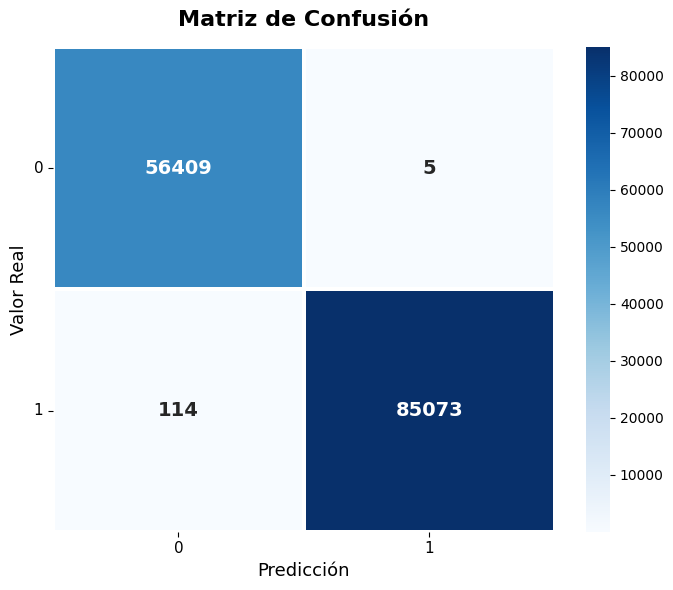

In [9]:
# Evaluar
Predicciones_prob = model.predict(X_test)
Predicciones = (Predicciones_prob > 0.5).astype("int32")

# --- Calcular matriz de confusión ---
cm = confusion_matrix(y_test, Predicciones)
labels = np.unique(y_test)  # etiquetas de clases detectadas

# --- Gráfica ---
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            annot_kws={"size": 14, "weight": "bold"}, cbar=True, linewidths=1.5)

# --- Estilo ---
plt.title('Matriz de Confusión', fontsize=16, pad=15, weight='bold')
plt.xlabel('Predicción', fontsize=13)
plt.ylabel('Valor Real', fontsize=13)

# Ajustes estéticos
plt.xticks(fontsize=11)
plt.yticks(fontsize=11, rotation=0)
plt.tight_layout()

# Mostrar
plt.show()

In [13]:
from sklearn.metrics import classification_report

print(classification_report(y_test, Predicciones, digits=4))

              precision    recall  f1-score   support

           0     0.9980    0.9999    0.9989     56414
           1     0.9999    0.9987    0.9993     85187

    accuracy                         0.9992    141601
   macro avg     0.9990    0.9993    0.9991    141601
weighted avg     0.9992    0.9992    0.9992    141601



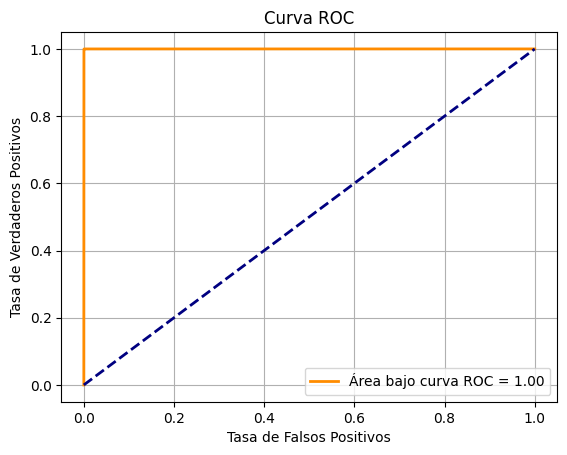

In [10]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, Predicciones_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Área bajo curva ROC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [11]:
# ----------------- Guardar modelo --------------------

# Mejor forma: guardar como .h5, NO usar pickle
model_filename = '/content/drive/MyDrive/IA/Investigacion /EMG/CNN-LSTM/modelo_cnn_lstm.h5'
model.save(model_filename)
print(f"Modelo guardado exitosamente en: {model_filename}")

Modelo guardado exitosamente en: /content/drive/MyDrive/IA/Investigacion /EMG/CNN-LSTM/modelo_cnn_lstm.h5


In [12]:
import time
import sys
import resource
import os

# Evaluate inference time
start_time = time.time()
predictions_time = model.predict(X_test)
end_time = time.time()
inference_time = end_time - start_time
print(f"Tiempo de inferencia: {inference_time:.4f} segundos")

# Evaluate memory consumption (approximate)
# This will give the size of the model object in bytes
model_memory = sys.getsizeof(model)
print(f"Consumo de memoria del modelo (aproximado): {model_memory} bytes")

# Evaluate RAM usage
# Note: This gives the maximum resident set size in kilobytes
# The units might vary depending on the system (e.g., resource.RUSAGE_SELF)
ram_usage = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
print(f"Uso de RAM (máximo): {ram_usage} KB")

# Evaluate disk space used by the model file
model_file_path = '/content/drive/MyDrive/IA/Investigacion /EMG/CNN/modelo_cnn.pkl'
if os.path.exists(model_file_path):
    disk_space = os.path.getsize(model_file_path)
    print(f"Espacio en disco utilizado por el modelo: {disk_space} bytes")
else:
    print(f"El archivo del modelo '{model_file_path}' no fue encontrado.")

4426/4426 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
Tiempo de inferencia: 9.3407 segundos
Consumo de memoria del modelo (aproximado): 48 bytes
Uso de RAM (máximo): 1056488 KB
El archivo del modelo '/content/drive/MyDrive/IA/Investigacion /EMG/CNN/modelo_cnn.pkl' no fue encontrado.
